<a href="https://colab.research.google.com/github/AkibCoding/Fake-news-detection-using-svm-kernel/blob/main/FakeNews_SVM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


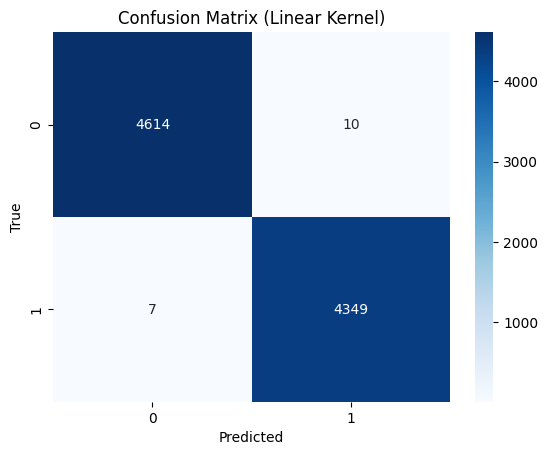

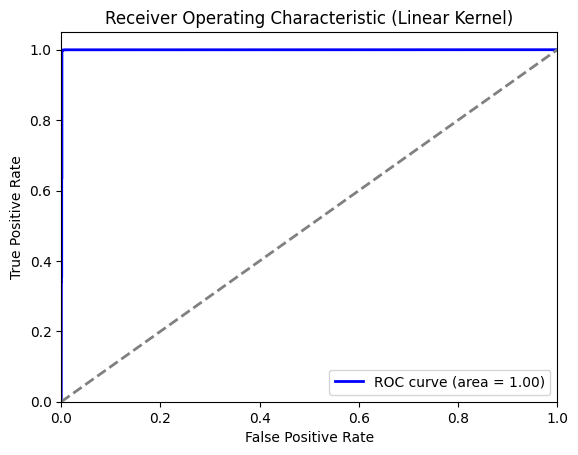

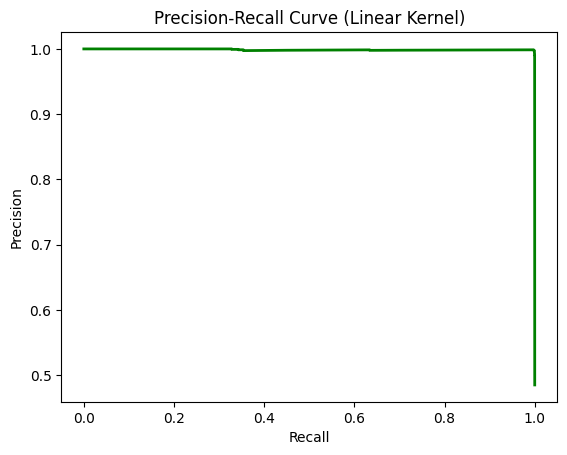

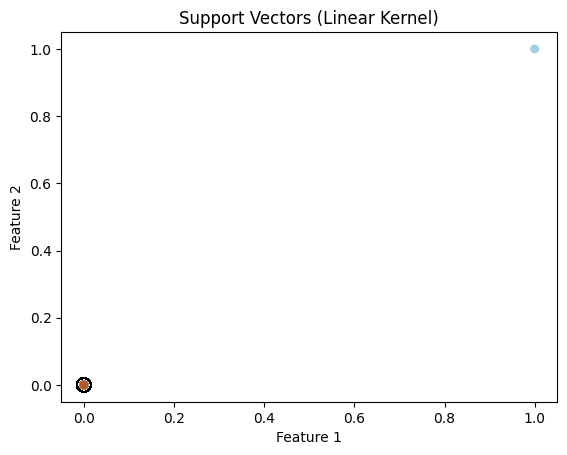

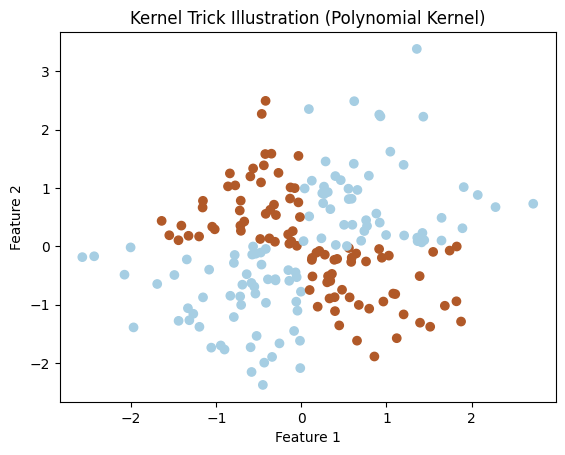

ValueError: could not convert string to float: 'As U.S. budget fight looms, Republicans flip their fiscal script'

<Figure size 1000x800 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from google.colab import drive

# Mounting Google Drive
drive.mount('/content/drive')

# Downloading NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Reading datasets
df_true = pd.read_csv("/content/drive/MyDrive/445_SVMFN/True.csv")
df_fake = pd.read_csv("/content/drive/MyDrive/445_SVMFN/Fake.csv")

# Labeling datasets
df_true['label'] = 1
df_fake['label'] = 0

# Combining datasets
df_all = pd.concat([df_true, df_fake]).reset_index(drop=True)

# Data Preprocessing
stop_words = stopwords.words('english')
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
    return result

def listToString(s):
    return " ".join(s)

df_all['processed_title'] = df_all['title'].apply(preprocess).apply(listToString)
df_all['processed_text'] = df_all['text'].apply(preprocess).apply(listToString)

# Train-test split
sampled = df_all.sample(frac=1, random_state=7, replace=True)
position = int(sampled.shape[0] * 0.8)
train = sampled.iloc[:position]
test = sampled.iloc[position:]

train = train.drop(columns=['text', 'title'])
test = test.drop(columns=['text', 'title'])

train = train.rename(columns={'processed_title': 'title', 'processed_text': 'text'})
test = test.rename(columns={'processed_title': 'title', 'processed_text': 'text'})

# Vectorization
CountVec = CountVectorizer(ngram_range=(1,2), lowercase=True)
vec_train = CountVec.fit(train.text)
X_vec_train = vec_train.transform(train.text)
X_vec_test = vec_train.transform(test.text)

tf_idf_vec = TfidfVectorizer(use_idf=True, ngram_range=(1,2), smooth_idf=True, lowercase=True)
vec_train_tf = tf_idf_vec.fit(train.text)
X_vec_train_tf = vec_train_tf.transform(train.text)
X_vec_test_tf = vec_train_tf.transform(test.text)

X = [x.split(' ') for x in train.text]
w2v = gensim.models.Word2Vec(sentences=X, vector_size=100, window=5, min_count=1)
train['doc_vector'] = train.text.apply(lambda doc: np.mean([w2v.wv[word] for word in doc.split(' ') if word in w2v.wv], axis=0))
test['doc_vector'] = test.text.apply(lambda doc: np.mean([w2v.wv[word] for word in doc.split(' ') if word in w2v.wv], axis=0))

X_train = np.array(list(train['doc_vector'].dropna()))
X_test = np.array(list(test['doc_vector'].dropna()))

y_train = train['label'][train['doc_vector'].apply(lambda x: x is not np.nan)]
y_test = test['label'][test['doc_vector'].apply(lambda x: x is not np.nan)]

# SVM Classification
svm_linear = SVC(kernel='linear', probability=True, random_state=0)
svm_linear.fit(X_vec_train, y_train)
y_pred_linear = svm_linear.predict(X_vec_test)
y_score_linear = svm_linear.decision_function(X_vec_test)

svm_rbf = SVC(kernel='rbf', probability=True, random_state=0)
svm_rbf.fit(X_vec_train, y_train)
y_pred_rbf = svm_rbf.predict(X_vec_test)
y_score_rbf = svm_rbf.decision_function(X_vec_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_linear)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Linear Kernel)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score_linear)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Linear Kernel)')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_score_linear)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Linear Kernel)')
plt.show()

# Support Vectors Plot
plt.scatter(X_vec_train[:, 0].toarray(), X_vec_train[:, 1].toarray(), c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(svm_linear.support_vectors_[:, 0].toarray(), svm_linear.support_vectors_[:, 1].toarray(), s=100, facecolors='none', edgecolors='k')
plt.title('Support Vectors (Linear Kernel)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Kernel Trick Illustration
X_sample = np.random.randn(200, 2)
y_sample = np.logical_xor(X_sample[:, 0] > 0, X_sample[:, 1] > 0)
svm_poly = SVC(kernel='poly', degree=3)
svm_poly.fit(X_sample, y_sample)
plt.scatter(X_sample[:, 0], X_sample[:, 1], c=y_sample, cmap=plt.cm.Paired)
plt.title('Kernel Trick Illustration (Polynomial Kernel)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_all.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 3D Scatter Plot
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_vec_train.toarray())
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_train, cmap=plt.cm.Paired)
ax.set_title('3D PCA Scatter Plot')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

# t-SNE Plot
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_vec_train.toarray())
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap=plt.cm.Paired)
plt.title('t-SNE Scatter Plot')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()


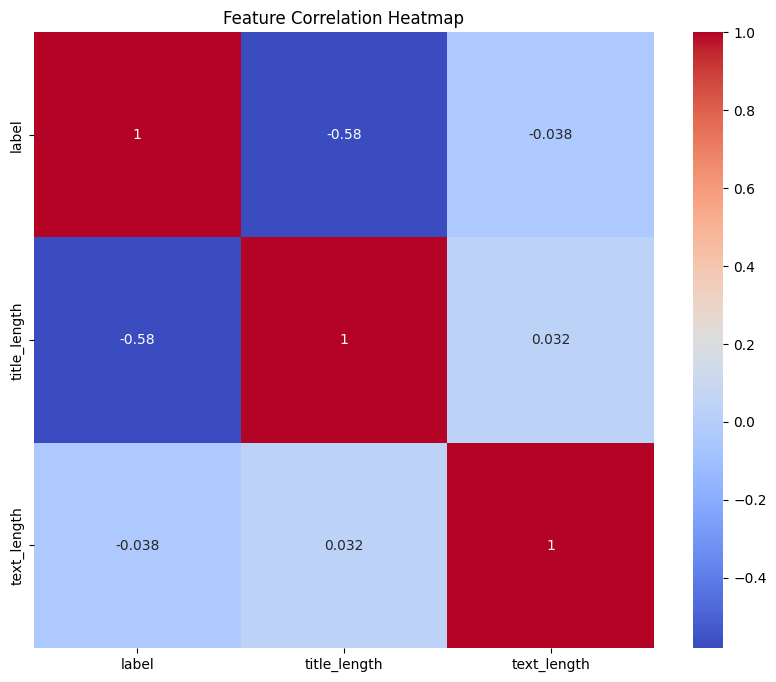

In [ ]:
# Adding numerical features for correlation analysis
df_all['title_length'] = df_all['title'].apply(len)
df_all['text_length'] = df_all['text'].apply(len)

# Heatmap - Including the numerical columns
plt.figure(figsize=(10,8))
numerical_df = df_all[['label', 'title_length', 'text_length']]
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


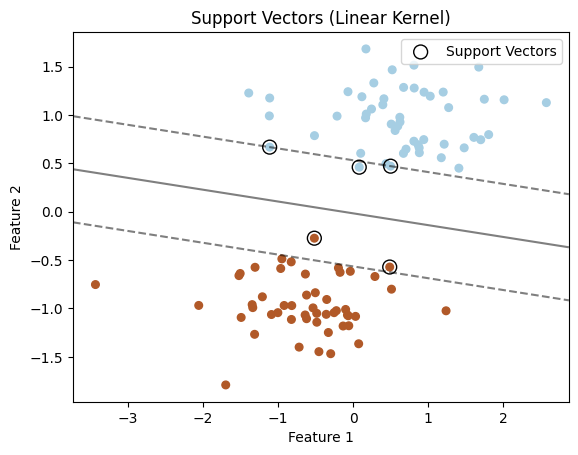

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load a sample dataset
X, y = datasets.make_blobs(n_samples=100, centers=2, random_state=6)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train the SVM model with a linear kernel
svm = SVC(kernel='linear', C=1)
svm.fit(X, y)

# Plot the data points and support vectors
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', label='Support Vectors')

# Plot the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.title("Support Vectors (Linear Kernel)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


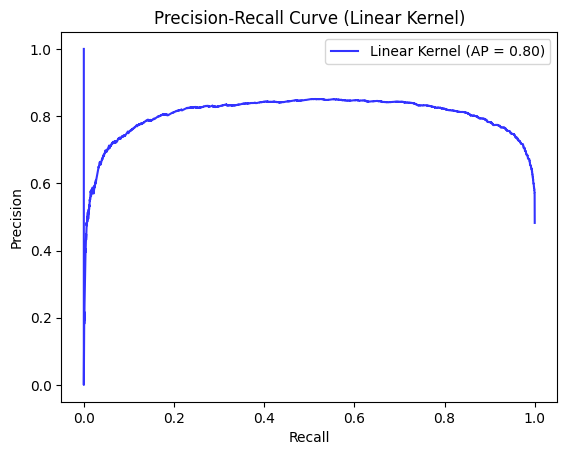

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd

# Assuming df_all is your DataFrame
X = df_all[['title_length', 'text_length']]
y = df_all['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the SVM model with a linear kernel
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Get the probabilities for the positive class
y_scores = svm.decision_function(X_test)

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Compute average precision score
average_precision = average_precision_score(y_test, y_scores)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='b', alpha=0.8, label=f'Linear Kernel (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Linear Kernel)')
plt.legend(loc='best')
plt.show()


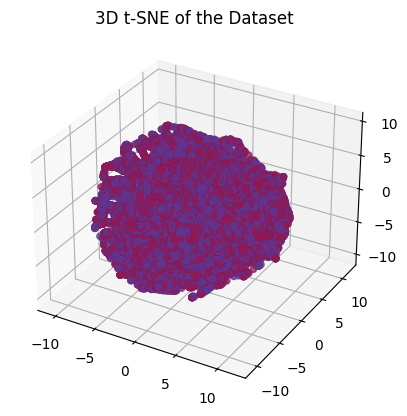

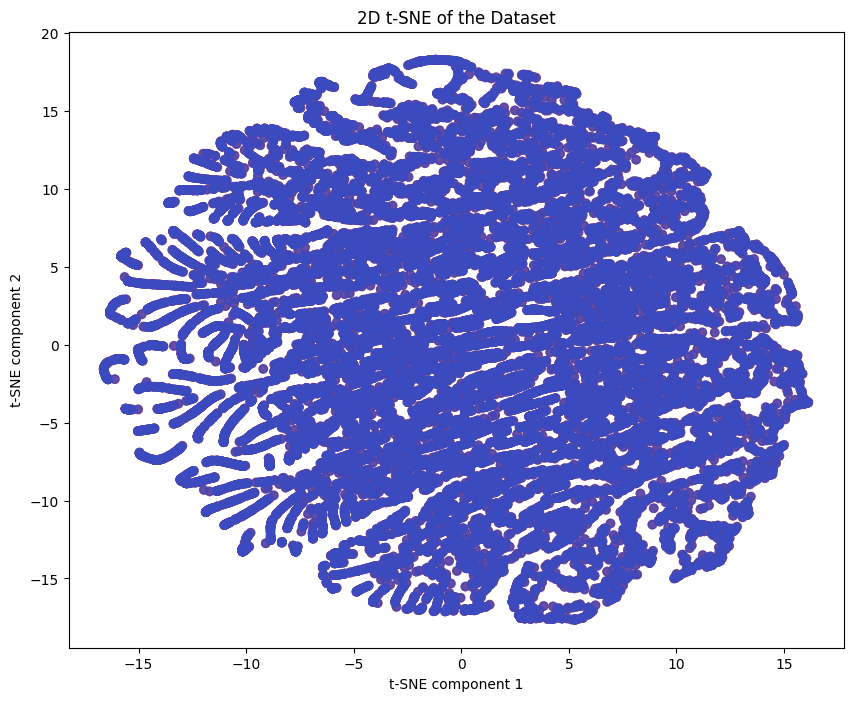

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Load your data
df_true = pd.read_csv("/content/drive/MyDrive/445_SVMFN/True.csv")  # Adjust the path to your True.csv
df_fake = pd.read_csv("/content/drive/MyDrive/445_SVMFN/True.csv")  # Adjust the path to your Fake.csv

# Add labels
df_true['label'] = 1
df_fake['label'] = 0

# Combine the datasets
df_all = pd.concat([df_true, df_fake]).reset_index(drop=True)

# Feature engineering (example)
df_all['title_length'] = df_all['title'].apply(len)
df_all['text_length'] = df_all['text'].apply(len)
df_all['num_words_title'] = df_all['title'].apply(lambda x: len(x.split()))
df_all['num_words_text'] = df_all['text'].apply(lambda x: len(x.split()))

# Define features and target
X = df_all[['title_length', 'text_length', 'num_words_title', 'num_words_text']]
y = df_all['label']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3D Scatter Plot using t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='coolwarm', alpha=0.5)
plt.title('3D t-SNE of the Dataset')
plt.show()

# 2D Scatter Plot using t-SNE
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('2D t-SNE of the Dataset')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()


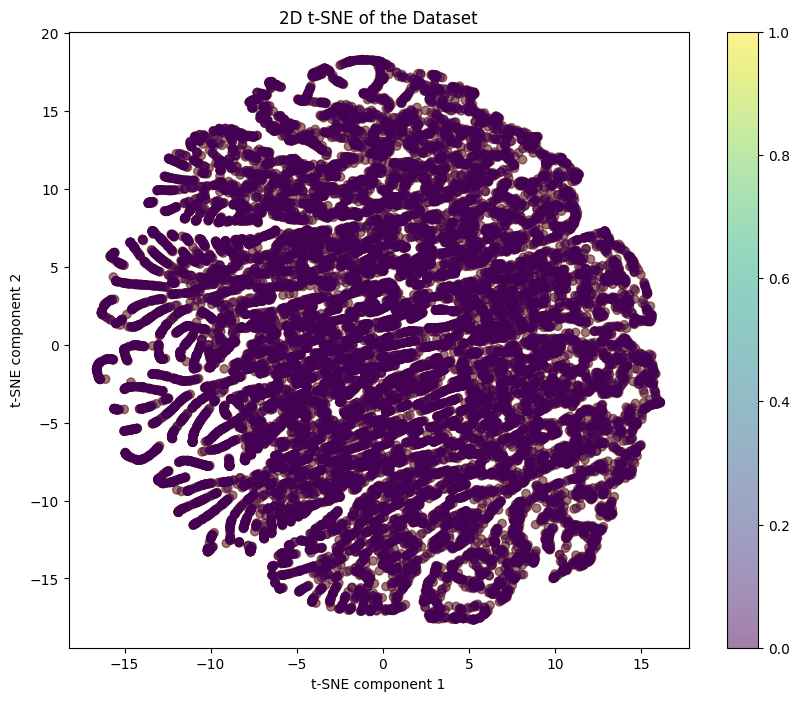

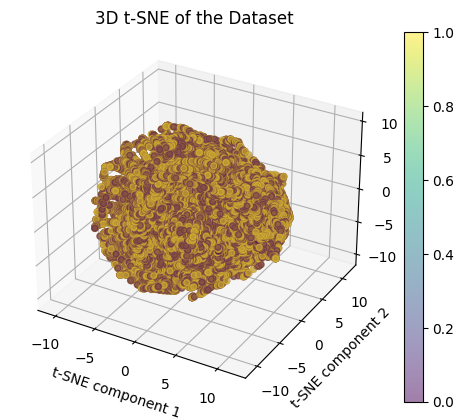

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have 'labels' to distinguish between fake and real news
labels = df_all['label']

# 2D t-SNE Plot
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('2D t-SNE of the Dataset')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar()
plt.show()

# 3D t-SNE Plot
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=labels, cmap='viridis', alpha=0.5)
plt.title('3D t-SNE of the Dataset')
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_zlabel('t-SNE component 3')
fig.colorbar(sc)
plt.show()


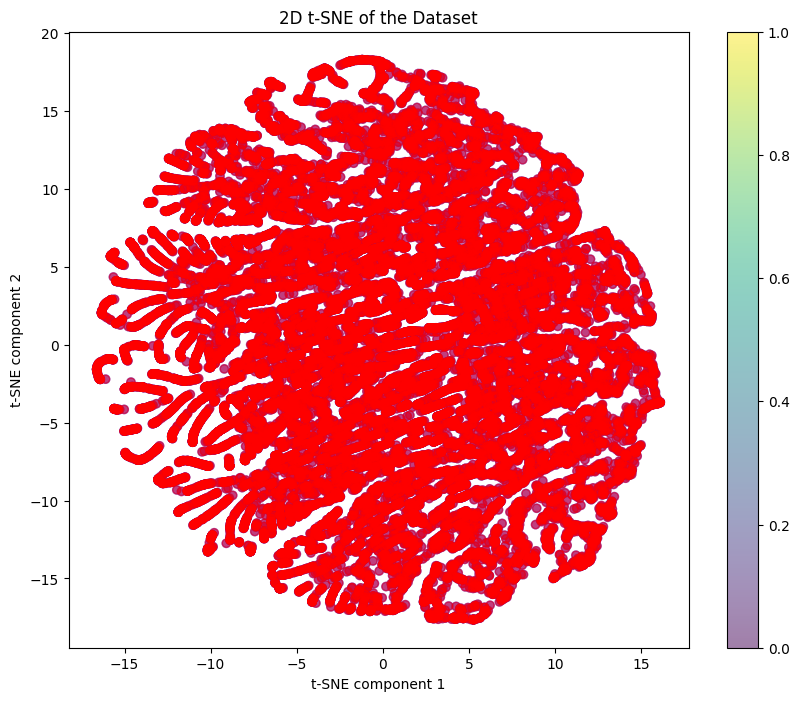

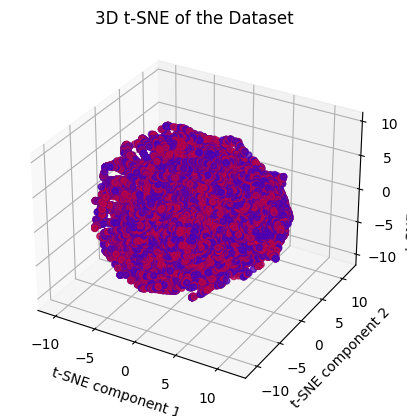

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have 'labels' to distinguish between fake (0) and real (1) news
labels = df_all['label']

# Define colors for labels
colors = ['red' if label == 0 else 'blue' for label in labels]

# 2D t-SNE Plot
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=colors, alpha=0.5)
plt.title('2D t-SNE of the Dataset')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar()
plt.show()

# 3D t-SNE Plot
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=0)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=colors, alpha=0.5)
plt.title('3D t-SNE of the Dataset')
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_zlabel('t-SNE component 3')
plt.show()


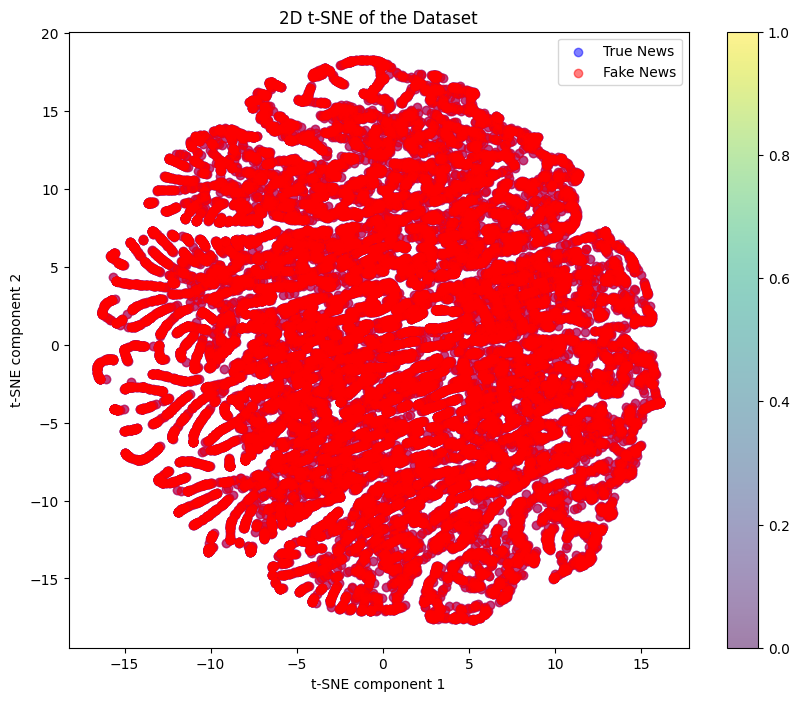

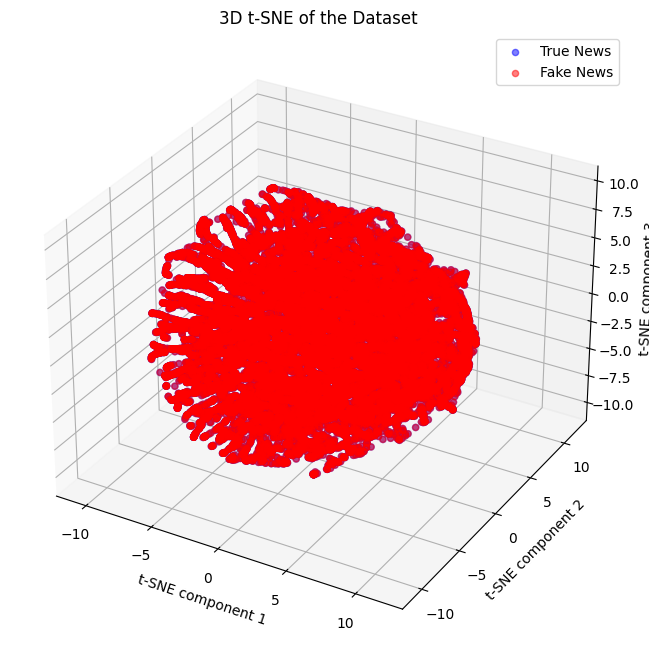

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_scaled is already available from previous preprocessing steps

# Add labels to the dataset
labels = np.concatenate([np.ones(df_true.shape[0]), np.zeros(df_fake.shape[0])])

# 2D t-SNE Plot
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne_2d = tsne_2d.fit_transform(X_scaled)

plt.figure(figsize=(10,8))
plt.scatter(X_tsne_2d[labels == 1, 0], X_tsne_2d[labels == 1, 1], c='blue', label='True News', alpha=0.5)
plt.scatter(X_tsne_2d[labels == 0, 0], X_tsne_2d[labels == 0, 1], c='red', label='Fake News', alpha=0.5)
plt.colorbar()
plt.title('2D t-SNE of the Dataset')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend()
plt.show()

# 3D t-SNE Plot
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=300)
X_tsne_3d = tsne_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne_3d[labels == 1, 0], X_tsne_3d[labels == 1, 1], X_tsne_3d[labels == 1, 2], c='blue', label='True News', alpha=0.5)
ax.scatter(X_tsne_3d[labels == 0, 0], X_tsne_3d[labels == 0, 1], X_tsne_3d[labels == 0, 2], c='red', label='Fake News', alpha=0.5)
ax.set_title('3D t-SNE of the Dataset')
ax.set_xlabel('t-SNE component 1')
ax.set_ylabel('t-SNE component 2')
ax.set_zlabel('t-SNE component 3')
ax.legend()
plt.show()
